<a href="https://colab.research.google.com/github/desstroyy/Covid-19-Detection-by-CT-Scan-Images/blob/main/SSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



### COVID 19 DETECTION USING CT SCAN IMAGES USING SELF-SUPERVISED LEARNING



1. IMPORTING PACKAGES

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision import datasets, transforms
import random
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from torch.cuda.amp import autocast, GradScaler
from torch.optim import Adam

2A. MOUNT GOOGLE DRIVE AND IMPORT THE IMAGES REQUIRED

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Path to the CT folder in your Google Drive
data_dir = '/content/drive/My Drive/CT'

# Folders for COVID and Non-COVID images
covid_dir = os.path.join(data_dir, 'COVID')
non_covid_dir = os.path.join(data_dir, 'non-COVID')

# Get a list of image paths for COVID and Non-COVID images
covid_image_paths = [os.path.join(covid_dir, img) for img in os.listdir(covid_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
non_covid_image_paths = [os.path.join(non_covid_dir, img) for img in os.listdir(non_covid_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

2B. PRINT SOME SAMPLE IMAGES

Sample COVID Images:


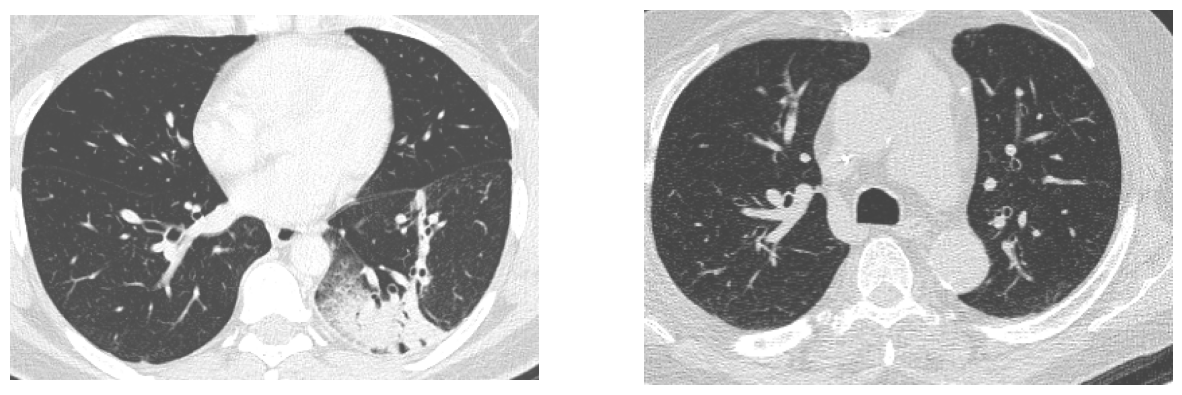

Sample Non-COVID Images:


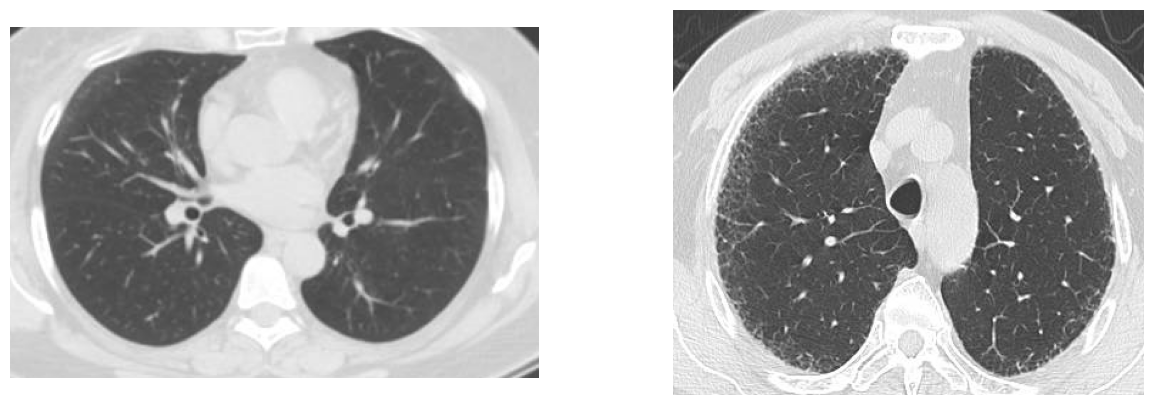

In [3]:
# Function to display images
def display_images(image_paths, num_images=2):
  plt.figure(figsize=(15, 5))
  for i in range(min(num_images, len(image_paths))):
    img = Image.open(image_paths[i])
    plt.subplot(1, num_images, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  plt.show()


# Display some COVID images
print("Sample COVID Images:")
display_images(covid_image_paths)

# Display some Non-COVID images
print("Sample Non-COVID Images:")
display_images(non_covid_image_paths)

3. PERFORMING AUGMENTATIONS TO IMAGES

In [4]:
aug_pipe=T.Compose([
    T.Resize((224,224)),
    T.RandomChoice([
        T.RandomHorizontalFlip(p=1),
        T.ColorJitter(brightness=0.2, contrast=0.2),
        T.RandomRotation(degrees=15),
        T.GaussianBlur(3),
        T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),

    ]),
    T.ToTensor()
])

3B. TESTING PIPELINE ON A SAMPLE IMAGE

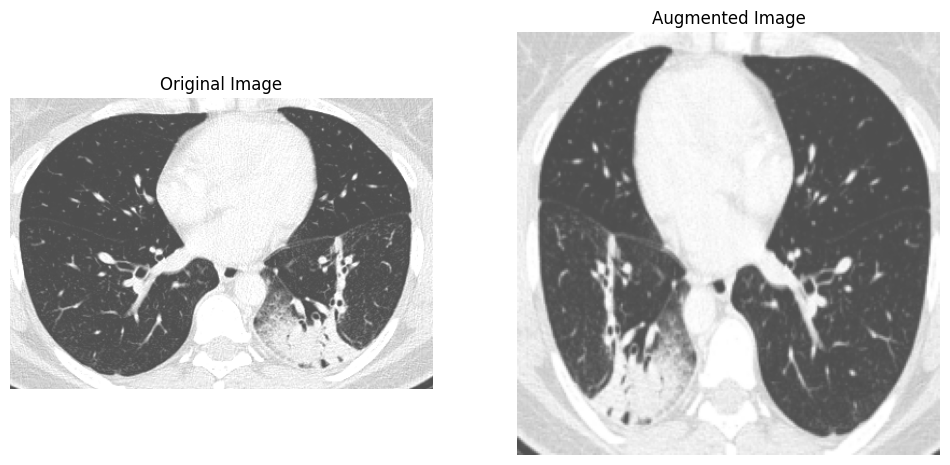

In [5]:
image = Image.open(covid_image_paths[0])

# Apply augmentations to the image
augmented_image = aug_pipe(image)
augmented_image_pil = T.ToPILImage()(augmented_image)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# original image
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')
# augmented image
ax[1].imshow(augmented_image_pil)
ax[1].set_title('Augmented Image')
ax[1].axis('off')
plt.show()

4A. CREATING CUSTOM DATSET

In [6]:
class CTDataset(Dataset):
  def __init__(self, img_dir1, img_dir2, transform=None):
    self.img_dir1 = img_dir1
    self.img_dir2 = img_dir2
    self.transform = transform
    self.image_files1 = [f for f in os.listdir(img_dir1) if os.path.isfile(os.path.join(img_dir1, f))]
    self.image_files2 = [os.path.join(img_dir2, f) for f in os.listdir(img_dir2) if os.path.isfile(os.path.join(img_dir2, f))]
    self.all_image_files = self.image_files1 + self.image_files2

  def __len__(self):
    return len(self.all_image_files)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir1, self.all_image_files[idx])
    img = Image.open(img_path).convert('L')
    img1 = img.copy()
    img2 = img.copy()
    if self.transform:
      img1 = self.transform(img1)
      img2 = self.transform(img2)

    return img1, img2

4B. CREATE DATA LOADERS

In [7]:
dataset=CTDataset(covid_dir, non_covid_dir, aug_pipe)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

5. DEFINT THE BYOL MODEL TO TRAIN THE NETWORK

In [8]:
#Projection Head for BYOL model
class ProjectionHead(nn.Module):
  def __init__(self, input_dim=512, hidden_dim=512, output_dim=128):
    super().__init__()
    self.l1=nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(),
    )
    self.l2=nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
    )
  def forward(self, x):
    x=self.l1(x)
    x=self.l2(x)
    return F.normalize(x, dim=1)


In [9]:
class BYOL(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder=resnet18(pretrained=False)
    self.encoder.conv1=nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
    self.encoder.fc=nn.Identity()
    self.projection_head=ProjectionHead(512)
    self.target_encoder=resnet18(pretrained=False)
    self.target_encoder.conv1=nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
    self.target_encoder.fc=nn.Identity()
    self.target_projection_head=ProjectionHead(input_dim=512)

    for op,tp in zip(self.encoder.parameters(), self.target_encoder.parameters()):
      tp.data.copy_(op.data)
      tp.requires_grad=False

  def target_update(self, tau=0.99):
    for op,tp in zip(self.encoder.parameters(), self.target_encoder.parameters()):
      tp.data=tp.data*tau+op.data*(1-tau)

  def forward(self, x):
    online_proj=self.projection_head(self.encoder(x))  # Using the correct attribute 'projection_head'
    with torch.no_grad():
      target_proj=self.target_projection_head(self.target_encoder(x))
    return online_proj, target_proj

  def loss(self, online_proj, target_proj):
    return 2-2*(online_proj*target_proj).sum(dim=-1).mean()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
byol = BYOL().to(device)
#Defining optimizer
optimizer = torch.optim.Adam(byol.parameters(), lr=3e-4)

#Defining scaler
scaler=GradScaler()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-11-5f8970405de6>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler=GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


6. MODEL TRAINING

In [12]:
#PATH TO SAVE MODEL AFTER CHECKPOINTS
os.makedirs(data_dir, exist_ok=True)

In [74]:
num_ep=5
for epoch in range(num_ep):
  byol.train()
  l=0
  for batch_idx, (imgs, _) in enumerate(train_loader):
    imgs=imgs.to(device)
    optimizer.zero_grad()
    with autocast():
      online_pred1, target_proj2=byol(imgs)
      online_pred2, target_proj1=byol(imgs)
      loss=byol.loss(online_pred1, target_proj2)+byol.loss(online_pred2, target_proj1)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    byol.target_update()
    l+=loss.item()

    if batch_idx%10==0:
      print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
      checkpoint_name = f'checkpoint_epoch_{epoch}_batch_{batch_idx}.pt'
      torch.save({
          'epoch': epoch,
          'batch': batch_idx,
          'model_state_dict': byol.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': loss.item(),
      }, os.path.join(data_dir, checkpoint_name))


    avg_loss=l/len(train_loader)
    print(f'Epoch: {epoch}, Loss: {avg_loss:.4f}')

<ipython-input-74-f79d99a95892>:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch: 0, Batch: 0, Loss: 0.3845
Epoch: 0, Loss: 0.0062
Epoch: 0, Loss: 0.0121
Epoch: 0, Loss: 0.0179
Epoch: 0, Loss: 0.0242
Epoch: 0, Loss: 0.0305
Epoch: 0, Loss: 0.0361
Epoch: 0, Loss: 0.0429
Epoch: 0, Loss: 0.0485
Epoch: 0, Loss: 0.0544
Epoch: 0, Loss: 0.0595
Epoch: 0, Batch: 10, Loss: 0.3479
Epoch: 0, Loss: 0.0651
Epoch: 0, Loss: 0.0709
Epoch: 0, Loss: 0.0762
Epoch: 0, Loss: 0.0820
Epoch: 0, Loss: 0.0886
Epoch: 0, Loss: 0.0957
Epoch: 0, Loss: 0.1014
Epoch: 0, Loss: 0.1068
Epoch: 0, Loss: 0.1126
Epoch: 0, Loss: 0.1187
Epoch: 0, Batch: 20, Loss: 0.4170
Epoch: 0, Loss: 0.1254
Epoch: 0, Loss: 0.1312
Epoch: 0, Loss: 0.1381
Epoch: 0, Loss: 0.1444
Epoch: 0, Loss: 0.1498
Epoch: 0, Loss: 0.1559
Epoch: 0, Loss: 0.1618
Epoch: 0, Loss: 0.1685
Epoch: 0, Loss: 0.1748
Epoch: 0, Loss: 0.1804
Epoch: 0, Batch: 30, Loss: 0.3647
Epoch: 0, Loss: 0.1863
Epoch: 0, Loss: 0.1921
Epoch: 0, Loss: 0.1991
Epoch: 0, Loss: 0.2058
Epoch: 0, Loss: 0.2123
Epoch: 0, Loss: 0.2192
Epoch: 0, Loss: 0.2252
Epoch: 0, Loss

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-74-f79d99a95892>", line 12, in <cell line: 2>
    scaler.scale(loss).backward()
  File "/usr/local/lib/python3.10/dist-packages/torch/_tensor.py", line 581, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py", line 347, in backward
    _engine_run_backward(
  File "/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py", line 825, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = v

TypeError: object of type 'NoneType' has no len()

7. LOADING THE MODEL

In [75]:
# Load the checkpoint
checkpoint = torch.load(os.path.join(data_dir,'byol2.pt'), map_location=torch.device('cpu'))

# Extract relevant information from the checkpoint
epoch = checkpoint['epoch']              # Epoch number when the checkpoint was saved
batch = checkpoint['batch']              # Batch number when the checkpoint was saved
model_state_dict = checkpoint['model_state_dict']  # Model's state dictionary (weights)
optimizer_state_dict = checkpoint['optimizer_state_dict']  # Optimizer's state dictionary
loss = checkpoint['loss']                # Loss value at the time of saving


<ipython-input-75-3274f8aa179d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(data_dir,'byol2.pt'), map_location=torch.device('cpu'))

In [76]:
byol = BYOL()  # Replace with the actual model class definition
byol.load_state_dict(model_state_dict)
optimizer.load_state_dict(optimizer_state_dict)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


8. EXTRACTING THE ONLINE ENCODER PART

In [77]:
encoder = byol.encoder  # Extract the encoder from the BYOL model
for param in encoder.parameters():
    param.requires_grad = False


9. CREATING CLASSIFICATION HEAD FOR DOWNSTREAM TASKS

In [78]:
class ClassificationHead(nn.Module):
    def __init__(self, encoder, num_classes=2):
        super(ClassificationHead, self).__init__()
        self.encoder=encoder
        self.fc=nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        return self.fc(self.encoder(x))

In [53]:
cmodel=ClassificationHead(encoder,2)

10. CREATING A LABELED DATASET FOR MODEL TRAINING

In [79]:
class LabeledDataset(Dataset):
  def __init__(self, covid_dir, non_covid_dir, num_samples=50):
    self.covid_dir = covid_dir
    self.non_covid_dir = non_covid_dir

    self.covid_image_paths = [os.path.join(covid_dir, img) for img in os.listdir(covid_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
    self.non_covid_image_paths = [os.path.join(non_covid_dir, img) for img in os.listdir(non_covid_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
    self.covid_images=random.sample(self.covid_image_paths, num_samples)
    self.non_covid_images=random.sample(self.non_covid_image_paths, num_samples)
    self.image_paths=self.covid_images+self.non_covid_images
    self.labels=[1]*num_samples+[0]*num_samples
    self.transform=T.Compose([
        T.Resize((224,224)),
        T.ToTensor()
    ])

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    label=self.labels[idx]
    img = Image.open(img_path).convert('L')
    img=self.transform(img)
    return img, label, img_path

In [80]:
labeled_ds=LabeledDataset(covid_dir, non_covid_dir, num_samples=50)
df_train, df_test = train_test_split(labeled_ds, test_size=0.2, random_state=42)

In [81]:
train_dl=DataLoader(df_train, batch_size=32, shuffle=True)
test_dl=DataLoader(df_test, batch_size=32, shuffle=True)

10. MODEL TRAINING

In [96]:
opt=Adam(cmodel.parameters(), lr=0.0001)

In [97]:
criterion = nn.CrossEntropyLoss()

# Example training loop
num_epochs = 20  # Adjust as needed
for epoch in range(num_epochs):
    cmodel.train()
    running_loss = 0.0

    for batch in train_dl:  # Assume `train_loader` is your DataLoader
        optimizer.zero_grad()
        outputs = cmodel(batch[0])
        labels = torch.tensor(batch[1])
        loss = criterion(outputs, labels)
        loss.backward()
        opt.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

<ipython-input-97-0628cbeab8d1>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch[1])


Epoch [1/20], Loss: 0.04459094736845263
Epoch [2/20], Loss: 0.043886045775105874
Epoch [3/20], Loss: 0.05068616136427848
Epoch [4/20], Loss: 0.05584886862385657
Epoch [5/20], Loss: 0.056372363721170736
Epoch [6/20], Loss: 0.04483858423848306
Epoch [7/20], Loss: 0.051727235317230225
Epoch [8/20], Loss: 0.04968680104901714
Epoch [9/20], Loss: 0.049025260633037936
Epoch [10/20], Loss: 0.06391659667415003
Epoch [11/20], Loss: 0.04885394727030108
Epoch [12/20], Loss: 0.037267100907141165
Epoch [13/20], Loss: 0.05032511584220394
Epoch [14/20], Loss: 0.05192485643971351
Epoch [15/20], Loss: 0.053646294340010614
Epoch [16/20], Loss: 0.04201251316455103
Epoch [17/20], Loss: 0.04910011637595392
Epoch [18/20], Loss: 0.04851725793653919
Epoch [19/20], Loss: 0.0487912489521888
Epoch [20/20], Loss: 0.04549826825818708


11. MODEL TESTING

In [98]:
all_outputs = []
all_labels = []
all_image_paths = []

cmodel.eval()  # Set the model to evaluation mode
with torch.no_grad(): #Disable gradient calculation for efficiency
    for batch in test_dl:
        images, labels, image_paths = batch
        images = images.to(device)
        outputs = cmodel(images)
        _, predicted = torch.max(outputs, 1)

        all_outputs.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_image_paths.extend(image_paths)

In [99]:
all_outputs

[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]

12. OBSERVING METRICS

In [100]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_outputs)
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.65
